# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage import img_as_float
from skimage.metrics import mean_squared_error
import cv2 as cv

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\Relu\AppData\Local\Temp\ipykernel_16944\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


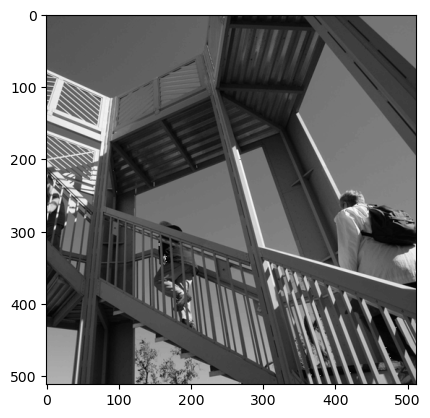

In [3]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

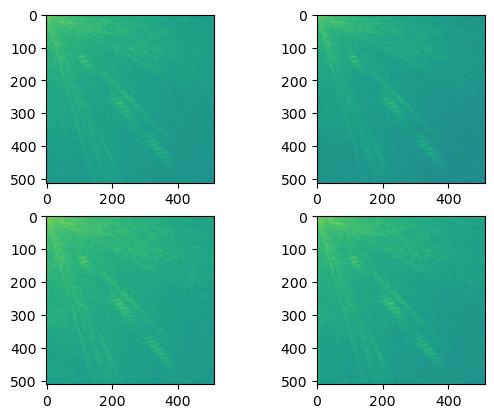

In [4]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

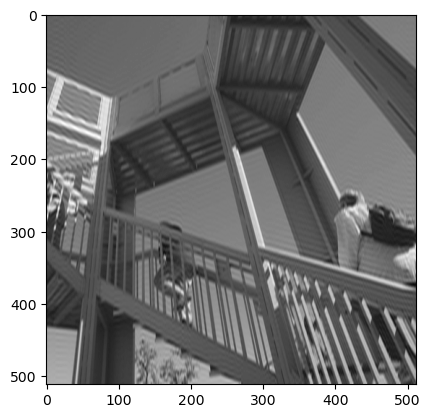

In [5]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

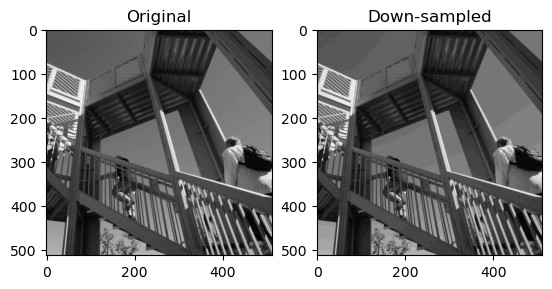

In [6]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

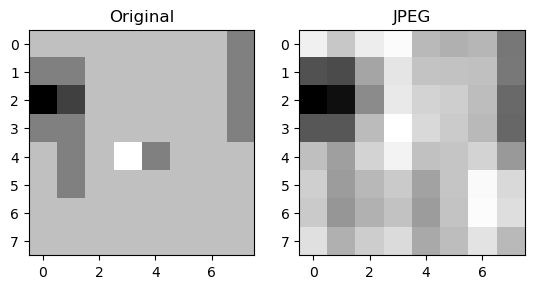

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [7]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

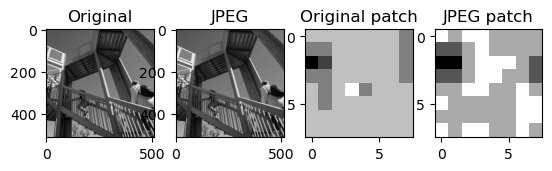

In [8]:
# Exercitiul 1
# Completati algoritmul JPEG incluzand toate blocurile din imagine.
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

h, w = X.shape
X_jpeg = np.zeros_like(X)
for i in range(0, h, 8):
    for j in range(0, w, 8):
        x_patch = X[i: i + 8, j: j + 8]
        y_patch = dctn(x_patch)
        y_patch_jpeg = Q_jpeg * np.round(y_patch / Q_jpeg)
        x_patch_jpeg = idctn(y_patch_jpeg)
        X_jpeg[i: i + 8, j: j + 8] = x_patch_jpeg

plt.subplot(141).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(142).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.subplot(143).imshow(X[0:8, 0:8], cmap=plt.cm.gray)
plt.title('Original patch')
plt.subplot(144).imshow(X_jpeg[0:8, 0:8], cmap=plt.cm.gray)
plt.title('JPEG patch')
plt.show()

C:\Users\Relu\AppData\Local\Temp\ipykernel_16944\2726566512.py:5: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X_rgb = misc.face()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


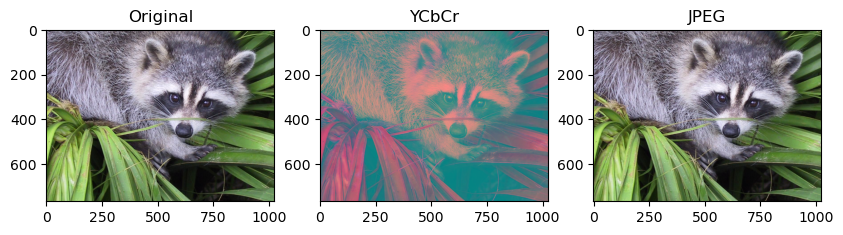

In [9]:
# Exercitiul 2
# Extindeti la imagini color (incluzand transformarea din RGB in Y'CbCr).
# Exemplificati pe scipy.misc.face folosita in tema anterioara.

X_rgb = misc.face()
X_rgb = img_as_float(X_rgb)
X_ycbcr = rgb2ycbcr(X_rgb)
X_ycbcr_norm = (X_ycbcr - X_ycbcr.min()) / (X_ycbcr.max() - X_ycbcr.min()) # Just for displaying because imshow expects values in [0, 1] for float images or [0, 255] for integers
plt.figure(figsize=(10, 5))
plt.subplot(131).imshow(X_rgb)
plt.title('Original')
plt.subplot(132).imshow(X_ycbcr_norm)
plt.title('YCbCr')
jpeg_img = np.zeros_like(X_ycbcr)
for channel in range(3):
    h, w = X_ycbcr[:, :, channel].shape
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            x_patch = X_ycbcr[i: i + 8, j: j + 8, channel]
            y_patch = dctn(x_patch)
            y_patch_jpeg = Q_jpeg * np.round(y_patch / Q_jpeg)
            x_patch_jpeg = idctn(y_patch_jpeg)
            jpeg_img[i: i + 8, j: j + 8, channel] = x_patch_jpeg
jpeg_img_rgb = ycbcr2rgb(jpeg_img)
plt.subplot(133).imshow(jpeg_img_rgb)
plt.title('JPEG')
plt.show()

MSE: 3.8978628248674916e-06 Scale factor: 1.0
MSE: 0.000344918332955075 Scale factor: 26.0
MSE: 0.0008662072358458695 Scale factor: 51.0
MSE: 0.0013747949188280988 Scale factor: 76.0
MSE: 0.0018607418860999972 Scale factor: 101.0
MSE: 0.002358756978886418 Scale factor: 126.0
MSE: 0.002859127640389771 Scale factor: 151.0
MSE: 0.003322170282869332 Scale factor: 176.0
MSE: 0.0038638848720368695 Scale factor: 201.0
MSE: 0.00430955378080455 Scale factor: 226.0
MSE: 0.004892582916746135 Scale factor: 251.0
MSE: 0.005521690854781 Scale factor: 276.0
MSE: 0.005490288416429484 Scale factor: 301.0
MSE: 0.006604869957736798 Scale factor: 326.0
MSE: 0.006349974564136776 Scale factor: 351.0
MSE: 0.008059092754087399 Scale factor: 376.0
MSE: 0.007724016176018551 Scale factor: 401.0
MSE: 0.0077464134625593655 Scale factor: 426.0
MSE: 0.009915520461483604 Scale factor: 451.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE: 0.0104698351031847 Scale factor: 476.0


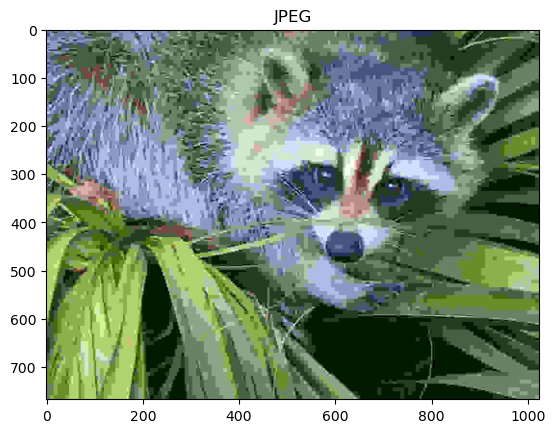

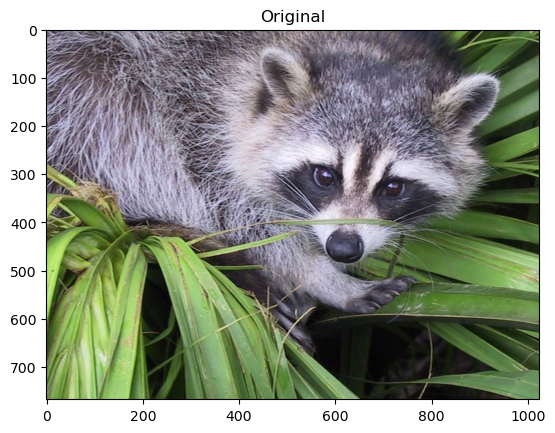

In [10]:
# Exercitiul 3
# Extindeti algoritmul pentru compresia imaginii pana la un prag MSE impus de utilizator.

mse_threshold = 0.01  

scale_factor = 1.0

Q_jpeg = np.array(Q_jpeg)

mse = 0

while mse < mse_threshold:
    Q_jpeg_scaled = Q_jpeg * scale_factor

    jpeg_img = np.zeros_like(X_ycbcr)

    for channel in range(3):
        h, w = X_ycbcr[:, :, channel].shape
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                x_patch = X_ycbcr[i: i + 8, j: j + 8, channel]
                y_patch = dctn(x_patch)
                y_patch_jpeg = Q_jpeg_scaled * np.round(y_patch / Q_jpeg_scaled)
                x_patch_jpeg = idctn(y_patch_jpeg)
                jpeg_img[i: i + 8, j: j + 8, channel] = x_patch_jpeg

    jpeg_img_rgb = ycbcr2rgb(jpeg_img)

    mse = mean_squared_error(X_rgb, jpeg_img_rgb)
    print('MSE: ' + str(mse) + ' Scale factor: ' + str(scale_factor))

    if mse < mse_threshold:
        scale_factor += 25

plt.figure()
plt.imshow(jpeg_img_rgb)
plt.title('JPEG')
plt.show()
plt.figure()
plt.imshow(X_rgb)
plt.title('Original')
plt.show()



In [20]:
# Exercitiul 4
# Extindeti algoritmul pentru compresie video. Demonstrati pe un clip scurt din care luati fiecare cadru si il tratati ca pe o imagine.
cap = cv.VideoCapture('cut_video.mp4')

frame_rate = cap.get(cv.CAP_PROP_FPS)
frame_size = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
print(frame_rate, frame_size)

fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('compressed_video.mp4', fourcc, frame_rate, frame_size)

scale_factor = 100.0

Q_jpeg = np.array(Q_jpeg)

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame_ycbcr = rgb2ycbcr(frame)

    Q_jpeg_scaled = Q_jpeg * scale_factor

    jpeg_img = np.zeros_like(frame_ycbcr)

    # Apply the JPEG encoding to the image
    for channel in range(3):
        h, w = frame_ycbcr[:, :, channel].shape
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                x_patch = frame_ycbcr[i: i + 8, j: j + 8, channel]
                y_patch = dctn(x_patch)
                y_patch_jpeg = Q_jpeg_scaled * np.round(y_patch / Q_jpeg_scaled)
                x_patch_jpeg = idctn(y_patch_jpeg)
                jpeg_img[i: i + 8, j: j + 8, channel] = x_patch_jpeg

    jpeg_img_rgb = ycbcr2rgb(jpeg_img)
    jpeg_img_rgb = (jpeg_img_rgb * 255).astype(np.uint8)

    out.write(jpeg_img_rgb)

cap.release()
out.release()

25.0 (1280, 720)


# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.